In [2]:

from models_otimizador_v2 import otimizador
import pandas as pd
import json
import pulp
import numpy as np
import logging
import matplotlib.pyplot as plt
import os

# Configurar o logging para mostrar mensagens INFO
# permitir uso de acentos no formato
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()  # Para mostrar no output do notebook
    ],
    style='%'
)

# Ou de forma mais simples:
logging.getLogger().setLevel(logging.INFO)


# configurar exibição do dataframe no notebook: sem limite de linhas e colunas e com valor sem estar em notação cientifica, mostrar divisão por milhar
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

plt.style.use('seaborn-v0_8-paper')

%load_ext autoreload
%reload_ext autoreload

%autoreload 2

# Seleção de opções

In [3]:
# lê dataframe do csv
options_df = pd.read_csv('entradas/options_v2.csv', index_col=0)

# # # adiciona nova linha no dataframe com as opções desejadas baseada em um dicionário
run = 7

option = {
    "NOME": "Cen2",
    "BOG_VAR": True,
    "CAPCOST": True,
    "LOCK_POLICY": True}

# adiciona nova coluna em options_df 
options_df.loc[run] = option

# # # salva dataframe em csv
options_df.to_csv('entradas/options_v2.csv', index=True)

In [77]:
options_df

,NOME,BOG_VAR,CAPCOST,LOCK_POLICY
RUN,,,,
1,Cen2,False,False,False
2,Cen2,True,False,False
3,Cen2,True,False,True
4,Cen2,False,True,False
5,Cen2,False,True,True
6,Cen2,True,True,False
7,Cen2,True,True,True


# Execução do Otimizador


In [ ]:
# Recupera as opções do dataframe

def executa_run(run, options_df):
    logging.info(f'Iniciando execução da run {run}...')

    arquivo_excel = 'entradas/entradas.xlsx'
    arquivo_json = 'entradas/entradas.json'

    # for run in range(1,8):
    # run = 1
    print(run)

    options = options_df.loc[run].to_dict()

    # Adiciona custo de capital aos dados de entrada se opção estiver ativada

    options['TIMELIMIT'] = 10800
    options["RUN"] = run
    logging.info(f'Rodando simulação {run} com opções: {options}')


    opt = otimizador(options["NOME"], arquivo_json, arquivo_excel, options)

    opt.solve_model()

    if opt.model.sol_status == 1:
        status = "Solução ótima encontrada"

    elif opt.model.sol_status == 2:
        status = "Solução encontrada"

    else:
        if opt.model.sol_status == 0:
            status = "ERRO! Nenhuma solução encontrada"

        elif opt.model.sol_status == -1:
            status = "ERRO! Problema sem solução"

        elif opt.model.sol_status == -2:
            status = "ERRO! Infinitas soluções possíveis"
    print(status)

    ## EXTRAÇÃO DE RESULTADOS

    opt.extrair_resultados()
    custos = opt.calcula_custos()

    if run == 1:
        arquivo_json = 'entradas/entradas.json'
        nome = options["NOME"]
        with open(arquivo_json, 'r', encoding='utf-8') as f:
            dados = json.load(f)

        dados[nome]["variaveis_fixadas"] = {}

        dados[nome]["variaveis_fixadas"]["x"] = opt.resultado_modelo["x"]
        dados[nome]["variaveis_fixadas"]["y"] = opt.resultado_modelo["y"]

        # salvar de volta no arquivo entradas.json
        with open('entradas/entradas.json', 'w', encoding='utf-8') as f:
            json.dump(dados, f, indent=4)


    ## SALVAR RESULTADOS

    # lê json de saídas
    saidas_json = json.load(open('saidas/saidas_v2.json', 'r'))

    # saidas_json = {}
    # adiciona novo resultado
    saidas_json[f"{run}"] = {
        'options': options,
        'status': status,
        'solution_time': opt.resultado_modelo["solution_time"],
        'objective_value': opt.resultado_modelo["objective_value"],
        'custos': custos
        }


    path = f'saidas/saidas_v2.json'
    with open(path, 'w') as f:
        json.dump(saidas_json, f, indent=4)
    return opt
        
        
def visualiza_resultados(opt: otimizador, run, options_df):        
    """Creates a compact operational overview chart."""
    options = options_df.loc[run].to_dict()
    os.makedirs('saidas/graficos_v2', exist_ok=True)

    T = list(opt.entradas["T"])
    J = opt.entradas["J"]
    J1 = range(len(J) - 1)
    I = opt.entradas["I"]
    nome = options["NOME"]

    # Normalized timeline for the horizontal axis
    x = np.arange(len(T))
    demand = np.array([sum(opt.entradas["V_d"][(i, t)] for i in I) for t in T], dtype=float)
    spot = np.array(opt.resultado_modelo["x"], dtype=float)
    inventory = np.array(opt.resultado_modelo["s"], dtype=float)

    palette = {
        "demand": "#cbd5f5",
        "spot": "#d97706",
        "inventory": "#000000ff",
        "bog": "#0f766e",
        "demurrage": "#dc2626"
    }
    spa_colors = ['#2563eb', '#7c3aed', '#0ea5e9', '#4338ca', '#0891b2']

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 4.0), dpi=300)  # Scales well when embedded in A4 text

    # Demand envelope
    ax.fill_between(x, 0, demand, color=palette["demand"], alpha=0.45, label='Total Demand', zorder=1)

    bar_width = 1.2
    ax.bar(x, spot, width=bar_width, color=palette["spot"], alpha=0.9, label='Spot Purchases', zorder=2)

    stack_base = spot.copy()
    demurrage_label_shown = False

    for idx, j in enumerate(J1):
        spa_regular = []
        spa_demurrage = []
        planning_marks = []
        prev_plan = 0
        for t in T:
            planned_cargo = opt.entradas['V_adp'][(j, t)]
            planning_marks.append(planned_cargo if planned_cargo and prev_plan == 0 else 0)
            prev_plan = planned_cargo

            purchase = planned_cargo * opt.resultado_modelo["y"][j][t]
            demurrage = opt.entradas['N_dem'][(j, t)] * opt.resultado_modelo["y"][j][t]
            if demurrage > 0:
                spa_demurrage.append(purchase)
                spa_regular.append(0)
            else:
                spa_regular.append(purchase)
                spa_demurrage.append(0)

        spa_regular = np.array(spa_regular, dtype=float)
        spa_demurrage = np.array(spa_demurrage, dtype=float)
        planning_marks = np.array(planning_marks, dtype=float)

        if planning_marks.any():
            ax.vlines(
                x[planning_marks > 0],
                ymin=0,
                ymax=planning_marks[planning_marks > 0],
                colors='#94a3b8',
                linestyles='dashed',
                linewidth=1.2,
                label='SPA Schedule' if idx == 0 else None,
                alpha=0.6,
                zorder=0
            )

        if spa_regular.any():
            ax.bar(
                x,
                spa_regular,
                width=bar_width,
                bottom=stack_base,
                color=spa_colors[idx % len(spa_colors)],
                alpha=0.85,
                label=f'SPA Cargo',
                zorder=3
            )
            stack_base += spa_regular

        demurrage_mask = spa_demurrage > 0
        if demurrage_mask.any():
            ax.bar(
                x[demurrage_mask],
                spa_demurrage[demurrage_mask],
                width=bar_width,
                bottom=stack_base[demurrage_mask],
                color=palette["demurrage"],
                alpha=0.95,
                edgecolor='white',
                linewidth=0.6,
                label='SPA Cargo w/ Demurrage' if not demurrage_label_shown else None,
                zorder=4
            )
            stack_base[demurrage_mask] += spa_demurrage[demurrage_mask]
            demurrage_label_shown = True

    # Inventory line
    ax.plot(x, inventory, color=palette["inventory"], linewidth=1.5, label='Inventory Level', zorder=5)

    # BOG series on secondary axis
    ax2 = None
    if opt.options.get("BOG_VAR", False):
        bog_series = np.array(opt.resultado_modelo["b"], dtype=float)
        if bog_series.any():
            ax2 = ax.twinx()
            ax2.plot(x, bog_series, color=palette["bog"], linewidth=1.0,
                     linestyle='--', label='BOG', zorder=6)
            ax2.set_ylabel('BOG (m³)', fontsize=11, color=palette["bog"])
            ax2.tick_params(axis='y', colors=palette["bog"], labelsize=10)
            ax2.grid(False)

    # General formatting
    tick_step = max(1, len(T)//12)
    ax.set_xticks(x[::tick_step])
    ax.set_xticklabels([str(T[i]) for i in range(0, len(T), tick_step)], rotation=0)
    ax.set_xlabel('Period', fontsize=12)
    ax.set_ylabel('Volume (m³)', fontsize=12)
    ax.set_title(f'Operational Plan — (Run {run})', fontsize=12, pad=40, fontweight='bold')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.grid(alpha=0.25)

    handles, labels = ax.get_legend_handles_labels()
    if ax2 is not None:
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles += handles2
        labels += labels2

    ax.legend(
        handles,
        labels,
        loc='upper right',
        bbox_to_anchor=(1.0,1.2),
        ncol=4,
        frameon=False,
        fontsize=9.5,
        columnspacing=1.0,
        handlelength=1.6
    )

    plt.savefig(f'saidas/graficos_v2/{nome}_run{run}_estoque_compras.png', bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()


2026-02-25 14:08:50,087 - INFO - Iniciando execução da run 1...
2026-02-25 14:08:50,096 - INFO - Rodando simulação 1 com opções: {'NOME': 'Cen2', 'BOG_VAR': False, 'CAPCOST': False, 'LOCK_POLICY': False, 'TIMELIMIT': 10800, 'RUN': 1}
2026-02-25 14:08:50,097 - INFO - Carregando parametros para o cenario Cen2.
2026-02-25 14:08:50,197 - INFO - Parametros carregados para o cenario Cen2. Iniciando otimizacao.
2026-02-25 14:08:50,199 - INFO - Iniciando definição do modelo de otimização.


1


2026-02-25 14:08:50,349 - INFO - Variaveis definidas com sucesso.
2026-02-25 14:08:50,351 - INFO - Solver definido com sucesso.
2026-02-25 14:08:50,376 - INFO - Funcao objetivo definida com sucesso.
2026-02-25 14:08:50,377 - INFO - Limite de inventario minimo para períodos PROD definido com sucesso.
2026-02-25 14:08:50,378 - INFO - Limite de intervalo entre chegadas definido com sucesso.
2026-02-25 14:08:50,411 - INFO - Limite de compra por intervalo definido com sucesso.
2026-02-25 14:08:50,512 - INFO - Problema definido com sucesso.
2026-02-25 14:08:51,242 - INFO - Problema resolvido com sucesso.


Solução ótima encontrada


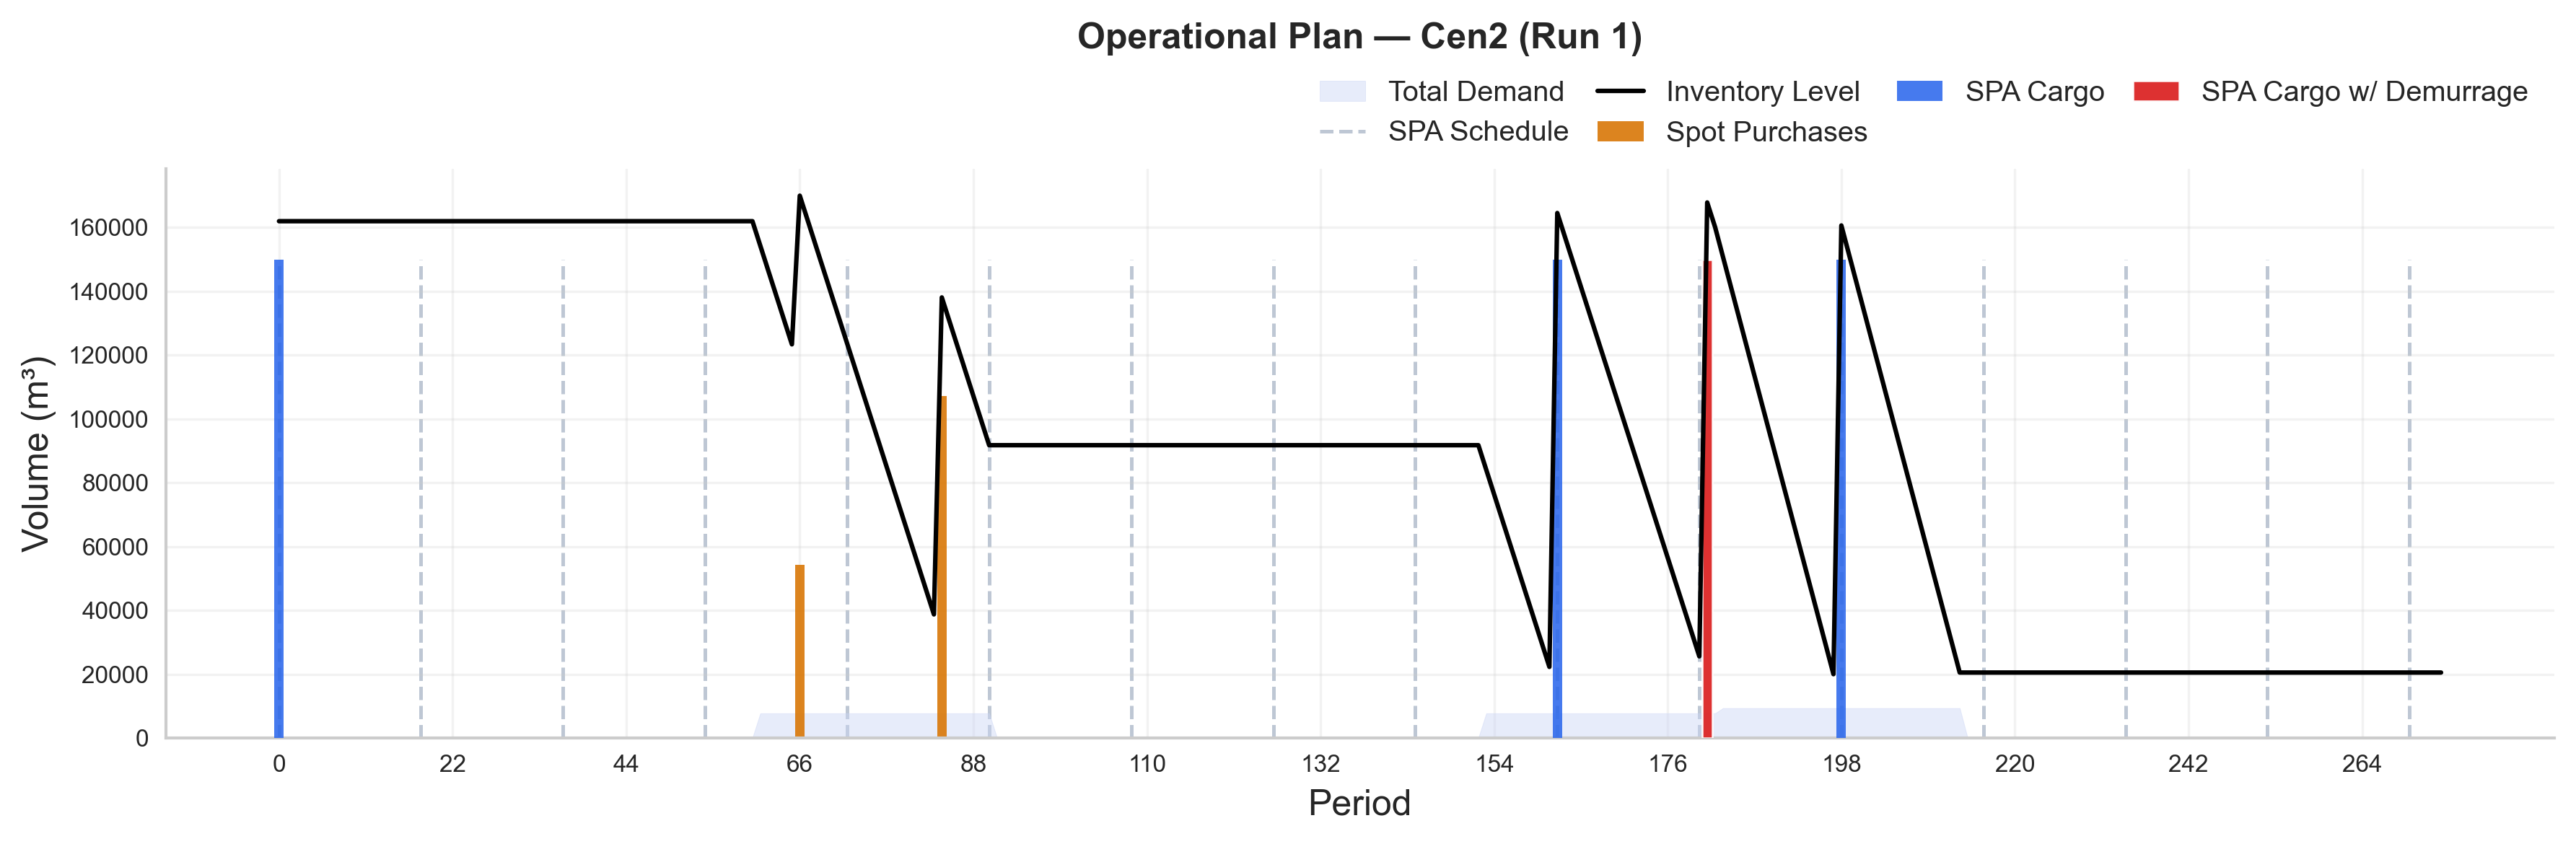

In [51]:
run = 1
opt = executa_run(run, options_df)
visualiza_resultados(opt, run, options_df)

# Extração de resultados

In [161]:
# opt.extrair_resultados()
# custos = opt.calcula_custos()

## Fixando variáveis

In [ ]:
# arquivo_json = 'entradas/entradas.json'
# nome = options["NOME"]
# with open(arquivo_json, 'r', encoding='utf-8') as f:
#     dados = json.load(f)

# dados[nome]["variaveis_fixadas"] = {}

# dados[nome]["variaveis_fixadas"]["x"] = opt.resultado_modelo["x"]
# dados[nome]["variaveis_fixadas"]["y"] = opt.resultado_modelo["y"]

# # salvar de volta no arquivo entradas.json
# with open('entradas/entradas.json', 'w', encoding='utf-8') as f:
#     json.dump(dados, f, indent=4)

# Escrita das saídas

In [166]:
# # lê json de saídas
# saidas_json = json.load(open('saidas/saidas_v2.json', 'r'))

# # saidas_json = {}
# # adiciona novo resultado
# saidas_json[f"{run}"] = {
#     'options': options,
#     'status': status,
#     'solution_time': opt.resultado_modelo["solution_time"],
#     'objective_value': opt.resultado_modelo["objective_value"],
#     'custos': custos
#     }


# path = f'saidas/saidas_v2.json'
# with open(path, 'w') as f:
#     json.dump(saidas_json, f, indent=4)

# Plot de resultados


In [167]:
# demanda = sum([sum([opt.entradas["D"][(i, t)] for i in I]) for t in T])
# preco = demanda*812
# print(demanda)
# print(preco)

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

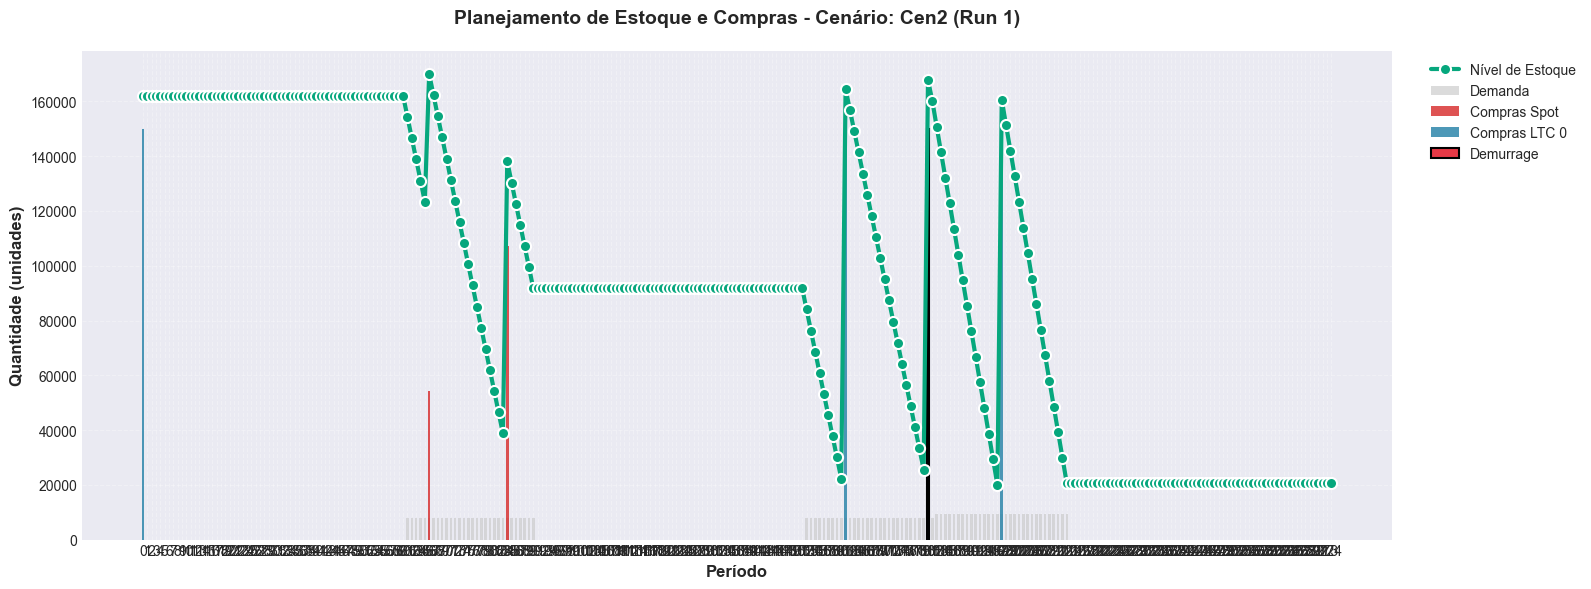

In [169]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# criar a pasta saidas/graficos se não existir
import os
os.makedirs('saidas/graficos_v2', exist_ok=True)

T = opt.entradas["T"]
J = opt.entradas["J"]
J1 = range(len(opt.entradas["J"]) - 1)
I = opt.entradas["I"]
nome = options["NOME"]

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')

# Cores personalizadas
cores_ltc = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']  # Cores para contratos LTC
cor_estoque = '#06A77D'
cor_spot = '#D62828'
cor_bog = '#F77F00'
cor_demanda = '#CCCCCC'

fig, ax = plt.subplots(figsize=(16, 6))

# Calcular offsets para barras empilhadas
width = 0.6
x_pos = np.array(T)

# Demanda (fundo cinzento)
demanda = [sum([opt.entradas["V_d"][(i, t)] for i in I]) for t in T]
ax.bar(x_pos, demanda, width=width, label="Demanda", color=cor_demanda, alpha=0.7, zorder=1)

# Compras Spot
ax.bar(x_pos, opt.resultado_modelo["x"], width=width, label="Compras Spot", 
       color=cor_spot, alpha=0.8, zorder=2)

# Compras LTC por contrato j
bottom_ltc = np.zeros(len(T))
for j in J1:
    # Extraindo planejamento de chegada de carga LTC
    i_0 = 0
    i_1 = 0
    W_date = []
    for t in T:
        i_0 = opt.entradas['V_adp'][(j,t)]
        if i_0 == 0:
            W_date.append(0)
        elif i_0 != 0 and i_1 == 0:
            W_date.append(i_0)
        else: 
            W_date.append(0)
        i_1 = i_0
    
    # Extraindo compras com demurrage e sem demurrage
    compras_ltc_regular = []
    compras_ltc_demurrage = []
    for t in T:
        compra = opt.entradas['V_adp'][(j, t)] * opt.resultado_modelo["y"][j][t]
        demurrage = opt.entradas['N_dem'][(j, t)] * opt.resultado_modelo["y"][j][t]
        if demurrage > 0:
            compras_ltc_demurrage.append(compra)
            compras_ltc_regular.append(0)
        else:
            compras_ltc_regular.append(compra)
            compras_ltc_demurrage.append(0)
    
    # Plotar compras LTC regulares (empilhadas)
    ax.bar(x_pos, compras_ltc_regular, width=width, bottom=bottom_ltc,
           label=f"Compras LTC {j}", color=cores_ltc[j % len(cores_ltc)], alpha=0.85, zorder=3)
    bottom_ltc = np.array(bottom_ltc) + np.array(compras_ltc_regular)
    
    # Plotar compras LTC com demurrage (destaque em padrão diferente)
    demurrage_indices = [i for i, d in enumerate(compras_ltc_demurrage) if d > 0]
    if demurrage_indices:
        for idx in demurrage_indices:
            ax.bar(x_pos[idx], compras_ltc_demurrage[idx], width=width, 
                   bottom=bottom_ltc[idx], color='#E63946', alpha=1.0, 
                   edgecolor='#000000', linewidth=1.5, zorder=4)
            bottom_ltc[idx] += compras_ltc_demurrage[idx]

# Nível do estoque (linha no topo)
ax.plot(T, opt.resultado_modelo["s"], label="Nível de Estoque", 
        color=cor_estoque, linewidth=3, marker='o', markersize=8, 
        zorder=5, markeredgecolor='white', markeredgewidth=1.5)

# Quantidade de BOG gerada (eixo direito)
if opt.options["BOG_VAR"]:
    ax2 = ax.twinx()
    ax2.plot(T, opt.resultado_modelo["b"], label="BOG", color=cor_bog, 
             linewidth=2.5, marker='s', markersize=7, linestyle='--', 
             zorder=6, alpha=0.9, markeredgecolor='white', markeredgewidth=1)
    ax2.set_ylabel("BOG (unidades)", fontsize=11, fontweight='bold', color=cor_bog)
    ax2.tick_params(axis='y', labelcolor=cor_bog, labelsize=10)
    ax2.grid(False)

# Formatação
ax.set_xlabel("Período", fontsize=12, fontweight='bold')
ax.set_ylabel("Quantidade (unidades)", fontsize=12, fontweight='bold')
ax.set_title(f"Planejamento de Estoque e Compras - Cenário: {nome} (Run {run})", 
             fontsize=14, fontweight='bold', pad=20)

# Melhorar a aparência do eixo X
ax.set_xticks(T)
ax.tick_params(axis='both', labelsize=10)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
ax.set_axisbelow(True)

# Legenda melhorada
handles, labels = ax.get_legend_handles_labels()
if opt.options["BOG_VAR"]:
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles + handles2
    labels = labels + labels2

# Adicionar marcador para demurrage na legenda
demurrage_patch = mpatches.Patch(facecolor='#E63946', edgecolor='#000000', 
                                  linewidth=1.5, label='Demurrage')
handles.append(demurrage_patch)
labels.append('Demurrage')

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1), 
         fontsize=10, framealpha=0.95, edgecolor='black', fancybox=True)

# Ajustar layout
plt.tight_layout()

# Salvar figura na pasta saidas com o nome do cenário e run
plt.savefig(f'saidas/graficos_v2/{nome}_run{run}_estoque_compras.png', 
            bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

# # Plot de linha com variáveis cc_acc, ca_acc, 
# fig, ax = plt.subplots(figsize=(12, 3))
# for j in J1:
#     ax.plot(T, opt.resultado_modelo["ca_acc"][j], label=f"ca_acc_j{j}")
#     ax.plot(T, opt.resultado_modelo["cc_acc"][j], label=f"cc_acc_j{j}")
    
# ax.set_xlabel("Período")
# ax.set_ylabel("Quantidade")
# ax.set_title("Variáveis Acumuladas e Contratos ao Longo do Tempo")
# ax.legend()
# # plt.savefig(f'saidas/graficos/{nome}_run{run}_variaveis_acumuladas.png', bbox_inches='tight')
# plt.show()

# # Plot de barra com variáveis lgc e topc para cada nível, contrato j e periodo t
# fig, ax = plt.subplots(figsize=(12, 3))
# for j in J1:
#     for c in opt.entradas["C"]:
#         ax.bar(
#             T,
#             opt.resultado_modelo["lgc"][j][c],
#             label=f"lgc_j{j}_c{c}"
#         )  
#     for m in opt.entradas["M"]:
#         ax.bar(
#             T,
#             opt.resultado_modelo["topc"][j][m],
#             label=f"topc_j{j}_m{m}"
#         )
# ax.set_xlabel("Período")
# ax.set_ylabel("Quantidade")
# ax.set_title("Variáveis lgc e topc ao Longo do Tempo")
# ax.legend()
# # plt.savefig(f'saidas/graficos/{nome}_run{run}_variaveis_lgc_topc.png', bbox_inches='tight')
# plt.show()

In [ ]:
# Heurística de operação da FSRU
# Algoritmo de regras lógicas que determina o valor de y_t para cada período t com base nas seguintes regras:
# 1. Se o nível de estoque s_t for menor que um limiar mínimo (S_idle_lo) deve-se contratar uma carga
# 1.1. a prioridade é contratar carga LTC se houver
# 1.2. se não houver carga LTC disponível, contratar carga spot
# 2. Só é possível contratar carga LTC se houver carga programada para aquele período (V_adp[j][t] > 0) e o volume é exatamente o mesmo da carga (V_adp[j][t])
# 3. O inventário obedece um balanço físico em que o estoque do período t+1 é igual ao estoque do período t mais as compras (spot e LTC) menos a demanda atendida (V_d[(i,t)] para cada i em I)


In [ ]:
# Heurística de operação da FSRU
def heuristica_operacao_fsru(S_idle_lo, T, ):
    """
    Determina o valor de y_t para cada período t com base em regras lógicas.
    Considera uma demanda de entrada Vd_t e um nível de estoque s_t para cada período t, e toma decisões de contratação de carga LTC (y_t) com base em limiares de estoque.
    
    Parâmetros:
    - s: lista com níveis de estoque para cada período
    - S_idle_lo: limiar mínimo de estoque
    - S_idle_hi: limiar máximo de estoque
    - T: lista de períodos
    - J1: range de contratos LTC
    - Vd: lista de demandas para cada período t (pode ser usada para decisões mais complexas)
    
    Retorna:
    - y: array com decisões de contratação
    """
    y = []
    s = []
    for t in T:
        # Regra 1: Se estoque baixo, contratar carga LTC
        if s[t] < S_idle_lo:
            for j in J1:
                y[j].append(1)
        # # Regra 2: Se estoque alto, não contratar
        # elif s[t] > S_idle_hi:
        #     for j in J1:
        #         y[j].append(0)
        # Regra 3: Estoque médio - manter operação atual ou decisão baseada em previsão
        else:
            for j in J1:
                # Pode ser refinado com mais regras
                y[j].append(0)
        s
    
    return y

# Exemplo de uso (descomente para testar):
# S_idle_lo = 10000  # Definir limiar mínimo
# S_idle_hi = 50000  # Definir limiar máximo
# y_heuristica = heuristica_operacao_fsru(opt.resultado_modelo["s"], S_idle_lo, S_idle_hi, T, J1)